# **Stock Price Prediction** #

## The University of Adelaide ##

### Completed by: ###
Name - Khaled Mahmud Pantha\
Student Id - a1932981\
Email - a1932981@adelaide.edu.au



*NOTE: The code has been written by me with assistance from several sources. The necessary sources have been mentioned wherever applicable*

## Importing the Necessary Libraries

In [26]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

import keras_tuner as kt
from keras_tuner import HyperModel

import matplotlib.pyplot as plt

## Loading the dataset ##

In [27]:
train_data = pd.read_csv('Google_Stock_Price_Train.csv')
test_data = pd.read_csv('Google_Stock_Price_Test.csv')

### Preprocessing the Data ###
#### *Adjusting the Data Types of Variables* ####

In [36]:
# Converting 'Date' to datetime type
train_data['Date'] = pd.to_datetime(train_data['Date'])
test_data['Date'] = pd.to_datetime(test_data['Date'])

# Converting other columns to float
# Assistance taken from https://stackoverflow.com/questions/22588316/pandas-applying-regex-to-replace-values
for col in ['Open', 'High', 'Low', 'Close', 'Volume']:
    train_data[col] = train_data[col].replace(',', '', regex=True).astype(float)
    test_data[col] = test_data[col].replace(',', '', regex=True).astype(float)

#### *Normalizing the data* ####

In [37]:
# Assistance taken from https://towardsdatascience.com/what-and-why-behind-fit-transform-vs-transform-in-scikit-learn-78f915cf96fe
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_data[['Open', 'High', 'Low', 'Close', 'Volume']])
test_scaled = scaler.transform(test_data[['Open', 'High', 'Low', 'Close', 'Volume']])


#### *Creating Sequences of Data* ####

In [5]:
# Function to create sequences of data
# Assistance from https://medium.com/@nikostsalkitzhs/temperature-forecasting-with-lstm-6741b1924750
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

In [6]:
time_step = 4
X_train, y_train = create_dataset(train_scaled, time_step)
X_test, y_test = create_dataset(test_scaled, time_step)

#### *Reshaping Data* ####

In [7]:
# Reshaping input to be [samples, time steps, features]
# Assistance from https://datascience.stackexchange.com/questions/46885/how-to-reshape-xtrain-array-and-what-about-input-shape
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

## Building the first Model ##
#### *Hyperparameter Tuning and finding the best parameter*s ####

In [8]:
# Assistance from https://machinelearningmastery.com/tune-lstm-hyperparameters-keras-time-series-forecasting/

def build_model(hp):
    model = Sequential()
    model.add(LSTM(
        units=hp.Int('units', min_value=50, max_value=200, step=50),
        return_sequences=True,
        input_shape=(X_train.shape[1], X_train.shape[2])  
    ))
    model.add(Dropout(hp.Float('dropout_1', min_value=0, max_value=0.5, step=0.1)))

    # Adding more LSTM layers based on the hyperparameter configuration
    for i in range(hp.Int('num_layers', 1, 3)):  # Adding between 1 and 3 LSTM layers
        model.add(LSTM(
            units=hp.Int(f'units_{i}', min_value=50, max_value=200, step=50),
            return_sequences=(i < hp.Int('num_layers', 1, 3) - 1)  # Only last layer doesn't return sequences
        ))
        model.add(Dropout(hp.Float(f'dropout_{i+2}', min_value=0, max_value=0.5, step=0.1)))

    model.add(Dense(1))
    model.compile(
        optimizer='adam',
        loss='mean_squared_error'
    )
    return model

# Initialising the tuner, here using the Random Search strategy
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,  # Number of different configurations to try
    executions_per_trial=1,  # Number of models to fit per configuration
    directory='model_tuning',
    project_name='stock_price_prediction'
)

# Executing the search
tuner.search(X_train, y_train, epochs=50, validation_split=0.2, batch_size=64)

Trial 10 Complete [00h 00m 38s]
val_loss: 0.000985794933512807

Best val_loss So Far: 0.0007506015826947987
Total elapsed time: 00h 05m 55s


### Optimal first Model ###

In [9]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
modelOne = tuner.hypermodel.build(best_hps)

modelOne.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 4, 200)         │       161,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 4, 200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 200)            │       320,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 482,601 (1.84 MB)

 Trainable params: 482,601 (1.84 MB)

 Non-trainable params: 0 (0.00 B)

### Retraining the Model ###

In [10]:
history = modelOne.fit(X_train, y_train, epochs=100, validation_split=0.2)

Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 0.0661 - val_loss: 0.0010
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 6.0435e-04 - val_loss: 9.9121e-04
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 7.5348e-04 - val_loss: 0.0013
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 6.7264e-04 - val_loss: 9.1286e-04
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 9.0138e-04 - val_loss: 8.3041e-04
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 6.1045e-04 - val_loss: 8.2489e-04
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 7.8967e-04 - val_loss: 9.4889e-04
Epoch 9/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 6.2817e-04 - val_loss: 8.7292e-04
Epoch 10/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 7.2856e-04 - val_loss: 0.0014
Epoch 11/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 6.8296e-04 - val_loss:

### Validating on Test Set ###

In [11]:
# Evaluate the model on test data
test_loss = modelOne.evaluate(X_test, y_test)
print(f"Test loss: {test_loss}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 2.5914e-04
Test loss: 0.00025913899298757315


#### Evaluating the Model Loss ####

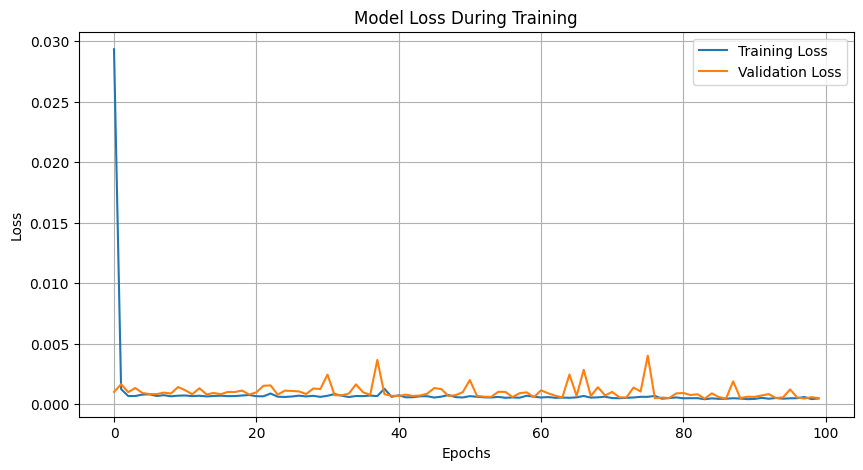

In [15]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### Cross Validating the Real and Predicted Prices ###

In [33]:
predicted_stock_price = modelOne.predict(X_test)
real_stock_price = y_test

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


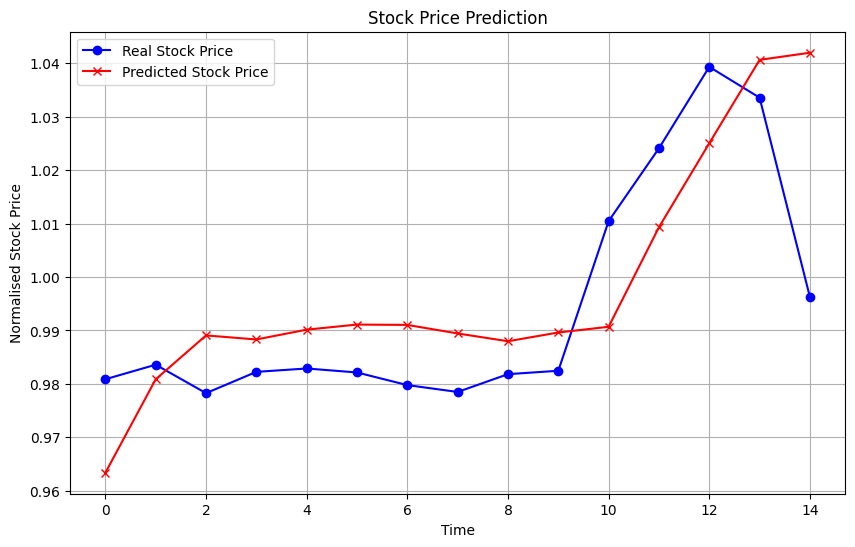

In [34]:
plt.figure(figsize=(10, 6))
plt.plot(real_stock_price, label='Real Stock Price', color='blue', marker='o')
plt.plot(predicted_stock_price, label='Predicted Stock Price', color='red', marker='x')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Normalised Stock Price')
plt.legend()
plt.grid(True)
plt.show()

## Building the Second Model ##
#### *Hyperparameter Tuning and finding the best parameters* ####

In [18]:
# Assistance from https://medium.com/@pennQuin/implementation-of-long-short-term-memory-lstm-81e35fa5ca54

def create_lstm_model(input_shape):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(LSTM(50, return_sequences=True))
    model.add(LSTM(50))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


def build_model(hp):
    model = Sequential([
        LSTM(
            units=hp.Int('units', min_value=30, max_value=100, step=10),
            input_shape=(X_train.shape[1], X_train.shape[2])
        ),
        Dense(1)
    ])
    model.compile(
        optimizer=Adam(
            hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
        ),
        loss='mean_squared_error'
    )
    return model


tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=3,
    directory='my_dir',
    project_name='stock_price_prediction - 2'
)

tuner.search(X_train, y_train, epochs=50, validation_split=0.2, batch_size=64)


Trial 10 Complete [00h 00m 34s]
val_loss: 0.0007780539842012028

Best val_loss So Far: 0.00048696305020712316
Total elapsed time: 00h 06m 05s


### Retraining the Model ###

In [19]:
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
modelTwo = tuner.hypermodel.build(best_hp)

history2 = modelTwo.fit(X_train, y_train, epochs=100, validation_split=0.2)

Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0457 - val_loss: 0.0026
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.6667e-04 - val_loss: 7.3707e-04
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.1685e-04 - val_loss: 7.1690e-04
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.9348e-04 - val_loss: 7.0001e-04
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.2494e-04 - val_loss: 8.8151e-04
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.2766e-04 - val_loss: 7.6458e-04
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.7095e-04 - val_loss: 0.0011
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.5867e-04 - val_loss: 7.4687e-04
Epoch 9/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.4253e-04 - val_loss: 8.7261e-04
Epoch 10/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.4572e-04 - val_loss: 6.4923e-04
Epoch 11/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.4424e-04 - val_los

### Validating on the Test Set ###

In [20]:
test_loss = modelTwo.evaluate(X_test, y_test)
print(f"Test loss: {test_loss}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.8812e-04
Test loss: 0.00018812324560713023


### Evaluating the Model Loss ###

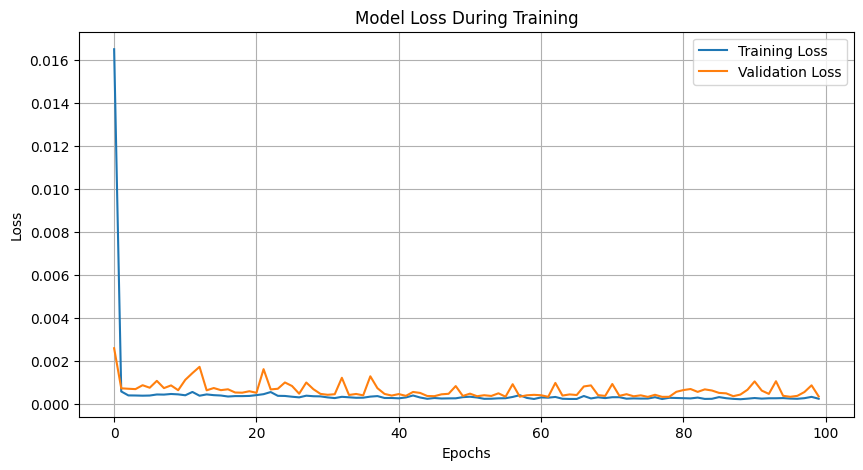

In [21]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


### Cross Validating the Real and Predicted Prices ###

In [22]:
predicted_stock_price = modelTwo.predict(X_test)
real_stock_price = y_test

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


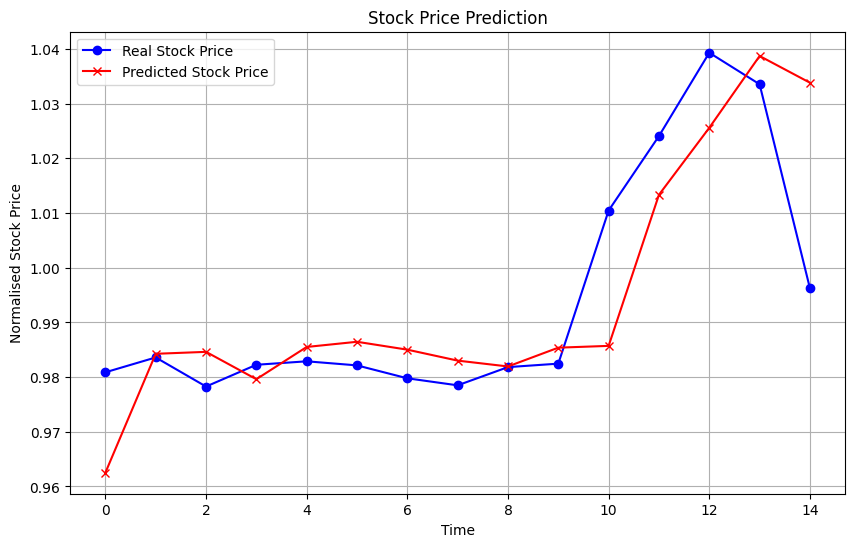

In [30]:
plt.figure(figsize=(10, 6))
plt.plot(real_stock_price, label='Real Stock Price', color='blue', marker='o')
plt.plot(predicted_stock_price, label='Predicted Stock Price', color='red', marker='x')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Normalised Stock Price')
plt.legend()
plt.grid(True)
plt.show()

## Comparing the Two models ##

In [31]:
predicted_stock_price_one = modelOne.predict(X_test)
predicted_stock_price_two = modelTwo.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


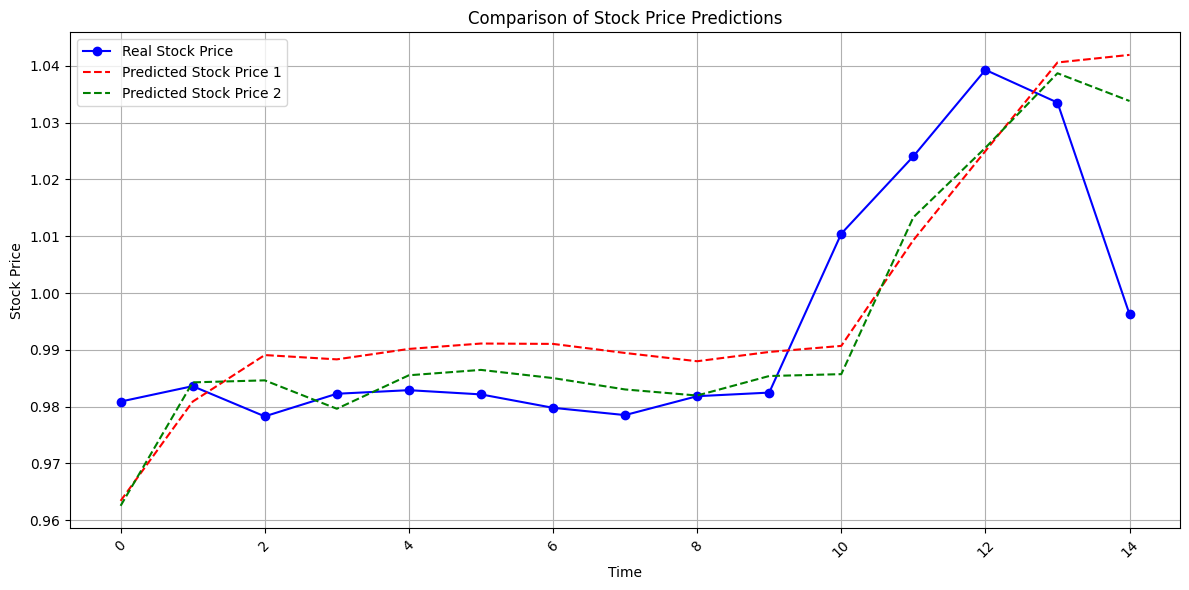

In [32]:
plt.figure(figsize=(12, 6))
plt.plot(real_stock_price, label='Real Stock Price', color='blue', marker='o', linestyle='-')
plt.plot( predicted_stock_price_one, label='Predicted Stock Price 1', color='red', marker=None, linestyle='--')
plt.plot( predicted_stock_price_two, label='Predicted Stock Price 2', color='green', marker=None, linestyle='--')

plt.title('Comparison of Stock Price Predictions')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  
plt.tight_layout()  
plt.show()